# 数据集说明

数据来源：2013年的TED演讲，数据集大小（中英文）30MB。

 Corpus Name: TED2013
     Package: TED2013 in Moses format
     Website: http://opus.nlpl.eu/TED2013-v1.1.php
     Release: v1.1
Release date: Sun Mar  4 00:46:11 EET 2018

This corpus is part of OPUS - the open collection of parallel corpora
OPUS Website: http://opus.nlpl.eu

Please cite the following article if you use any part of the corpus in your own work: J. Tiedemann, 2012, Parallel Data, Tools and Interfaces in OPUS. In Proceedings of the 8th International Conference on Language Resources and Evaluation (LREC 2012)

A parallel corpus of TED talk subtitles provided by CASMACAT: http://www.casmacat.eu/corpus/ted2013.html. The files are originally provided by https://wit3.fbk.eu.


# 载入库

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import sentencepiece as spm
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
# 防止缓存不释放
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# 数据读取

In [3]:
# 固定随机种子，保证可复现
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 读取并预处理数据
def read_ted_data(zh_path: str, en_path: str):
    with open(zh_path, encoding='utf-8') as f:
        zh_lines = f.readlines()[1:]
    with open(en_path, encoding='utf-8') as f:
        en_lines = f.readlines()[1:]
    if len(zh_lines) != len(en_lines):
        raise ValueError(f"中英文行数不一致：zh={len(zh_lines)}, en={len(en_lines)}")
    pairs = [(zh.strip(), en.strip())
             for zh, en in zip(zh_lines, en_lines)
             if zh.strip() and en.strip()]
    zh_lines, en_lines = zip(*pairs)
    return list(zh_lines), list(en_lines)

In [5]:
# 路径配置
zh_path = "TED2013.en-zh_zh.txt"
en_path = "TED2013.en-zh_en.txt"
zh_sentences, en_sentences = read_ted_data(zh_path, en_path)
print(f"样本数: {len(zh_sentences)}")

样本数: 154578


# 分词训练

In [ ]:
# 导出到文件并训练 SentencePiece
with open("ted.zh", "w", encoding="utf-8") as f:
    f.write("\n".join(zh_sentences))
with open("ted.en", "w", encoding="utf-8") as f:
    f.write("\n".join(en_sentences))

spm.SentencePieceTrainer.Train(
    input='ted.zh',                # 中文语料，每行一句
    model_prefix='zh',             # zh前缀（输出为 zh.model 和 zh.vocab）
    vocab_size=16000,              # 子词表大小
    character_coverage=0.9995,     # 覆盖 99.95% 的字符
    model_type='bpe',              # 使用 BPE 算法
    input_sentence_size=1000000,   # 最多抽取 100 万句训练
    shuffle_input_sentence=True    # 打乱输入语料
)
spm.SentencePieceTrainer.Train(
    input='ted.en', 
    model_prefix='en',
    vocab_size=16000, 
    character_coverage=1.0,
    model_type='bpe',
    input_sentence_size=1000000,
    shuffle_input_sentence=True
)

sp_zh = spm.SentencePieceProcessor(model_file="zh.model")
sp_en = spm.SentencePieceProcessor(model_file="en.model")

In [ ]:
# 打印 SentencePiece 模型里的特殊 id
print("中文 BOS ID:", sp_zh.bos_id(), "EOS ID:", sp_zh.eos_id(), "UNK ID:", sp_zh.unk_id())
print("英文 BOS ID:", sp_en.bos_id(), "EOS ID:", sp_en.eos_id(), "UNK ID:", sp_en.unk_id())
print("中文词表大小:", sp_zh.GetPieceSize())
print("英文词表大小:", sp_en.GetPieceSize())

中文 BOS ID: 1 EOS ID: 2 UNK ID: 0
英文 BOS ID: 1 EOS ID: 2 UNK ID: 0
中文词表大小: 16000
英文词表大小: 16000


In [ ]:
# 检查编码—解码一致性
def test_roundtrip(sp, text):
    ids = sp.EncodeAsIds(text)
    text2 = sp.DecodeIds(ids)
    return text, ids[:20], text2[:len(text)]  # 限制输出长度

samples = [
    "今天天气很好，我们去郊游吧。",
    "This is a test sentence.",
    "含有罕见字符：🤔🔥💯"
]

for s in samples:
    orig, ids, dec = test_roundtrip(sp_zh, s)
    print(f"原文: {orig}\nIDs: {ids}\n解码: {dec}\n")


原文: 今天天气很好，我们去郊游吧。
IDs: [893, 5113, 841, 12441, 8602, 14399, 12953, 12846, 12443]
解码: 今天天气很好,我们去郊游吧。

原文: This is a test sentence.
IDs: [1268, 12533, 262, 1437, 9703, 12439, 76, 2408, 8476, 110, 9136, 459, 12503]
解码: This is a test sentence.

原文: 含有罕见字符：🤔🔥💯
IDs: [12439, 5859, 14110, 12778, 12315, 12524, 0]
解码: 含有罕见字符: ⁇ 



In [ ]:
# 未知 token（UNK） 统计
unk_id = sp_zh.unk_id()
total_tokens = 0
unk_count = 0

for line in zh_sentences:
    ids = sp_zh.EncodeAsIds(line)
    total_tokens += len(ids)
    unk_count += sum(1 for i in ids if i == unk_id)

print(f"中文总 token 数: {total_tokens}, UNK 数: {unk_count}, UNK 比例: {unk_count/total_tokens:.2%}")

for line in en_sentences:
    ids = sp_en.EncodeAsIds(line)
    total_tokens += len(ids)
    unk_count += sum(1 for i in ids if i == unk_id)

print(f"英文总 token 数: {total_tokens}, UNK 数: {unk_count}, UNK 比例: {unk_count/total_tokens:.2%}")

中文总 token 数: 2651882, UNK 数: 2282, UNK 比例: 0.09%
英文总 token 数: 6020150, UNK 数: 2282, UNK 比例: 0.04%


In [ ]:
# 长度／分布异常分析
lengths = [len(sp_zh.EncodeAsIds(line)) for line in zh_sentences]
print("中文 token 序列长度：", "min", np.min(lengths), "mean", np.mean(lengths), "max", np.max(lengths))

lengths = [len(sp_en.EncodeAsIds(line)) for line in en_sentences]
print("英文 token 序列长度：", "min", np.min(lengths), "mean", np.mean(lengths), "max", np.max(lengths))

中文 token 序列长度： min 1 mean 17.15562369806829 max 590
英文 token 序列长度： min 1 mean 21.79008655824244 max 816


In [ ]:
for line in zh_sentences[:5]:
    ids = sp_zh.EncodeAsPieces(line)  # 返回 piece 字符串列表
    print(line)
    print("Tokens:", ids)
    print()

生物学家史蒂芬·帕伦认为，海洋的健康和我们的健康之间有着紧密而神奇的联系。他通过日本一个渔场发生的让人震惊的有毒污染的事件，展示了位于海洋食物链底部的有毒物质是如何进入我们的身体的。他的工作主要是未来拯救海洋健康的方法——同时也包括人类的。
Tokens: ['▁', '生物学家', '史蒂芬', '·', '帕', '伦', '认为', ',', '海洋的', '健康和', '我们的', '健康', '之间', '有着', '紧密', '而', '神奇的', '联系', '。', '他', '通过', '日本', '一个', '渔', '场', '发生的', '让人', '震惊', '的', '有毒', '污染', '的事件', ',', '展示了', '位于', '海洋', '食物链', '底', '部的', '有毒', '物质', '是如何', '进入', '我们的', '身体的', '。', '他的', '工作', '主要是', '未来', '拯救', '海洋', '健康', '的方法', '——', '同时也', '包括', '人类的', '。']

fish,health,mission blue,oceans,science
Tokens: ['▁', 'f', 'ish', ',', 'health', ',', 'm', 'iss', 'ion', '▁b', 'l', 'ue', ',', 'oceans', ',', 'science']

899
Tokens: ['▁8', '99']

史蒂芬·帕伦：追寻水银的踪迹
Tokens: ['▁', '史蒂芬', '·', '帕', '伦', ':', '追寻', '水', '银', '的', '踪', '迹']

海洋是一个非常复杂的事物。
Tokens: ['▁海洋', '是一个非常', '复杂', '的事物', '。']



In [ ]:
for line in en_sentences[:5]:
    ids = sp_en.EncodeAsPieces(line)  # 返回 piece 字符串列表
    print(line)
    print("Tokens:", ids)
    print()

There's a tight and surprising link between the ocean's health and ours, says marine biologist Stephen Palumbi. He shows how toxins at the bottom of the ocean food chain find their way into our bodies, with a shocking story of toxic contamination from a Japanese fish market. His work points a way forward for saving the oceans' health -- and humanity's.
Tokens: ['▁There', "'", 's', '▁a', '▁tight', '▁and', '▁surprising', '▁link', '▁between', '▁the', '▁ocean', "'", 's', '▁health', '▁and', '▁ours', ',', '▁says', '▁marine', '▁biologist', '▁Stephen', '▁Pal', 'umb', 'i', '.', '▁He', '▁shows', '▁how', '▁toxins', '▁at', '▁the', '▁bottom', '▁of', '▁the', '▁ocean', '▁food', '▁chain', '▁find', '▁their', '▁way', '▁into', '▁our', '▁bodies', ',', '▁with', '▁a', '▁shocking', '▁story', '▁of', '▁toxic', '▁contam', 'ination', '▁from', '▁a', '▁Japanese', '▁fish', '▁market', '.', '▁His', '▁work', '▁points', '▁a', '▁way', '▁forward', '▁for', '▁saving', '▁the', '▁oceans', "'", '▁health', '▁--', '▁and', '▁hum

In [ ]:
def print_length_percentiles(lines, sp, language_name="src"):
    lengths = [len(sp.EncodeAsIds(line)) for line in lines]
    p90, p95, p99 = np.percentile(lengths, [90, 95, 99])
    print(f"{language_name} sentence length percentiles:")
    print(f"  90% of sentences <= {p90:.0f} tokens")
    print(f"  95% of sentences <= {p95:.0f} tokens")
    print(f"  99% of sentences <= {p99:.0f} tokens")

print_length_percentiles(zh_sentences, sp_zh, "Chinese")
print_length_percentiles(en_sentences, sp_en, "English")

Chinese sentence length percentiles:
  90% of sentences <= 33 tokens
  95% of sentences <= 41 tokens
  99% of sentences <= 62 tokens
English sentence length percentiles:
  90% of sentences <= 41 tokens
  95% of sentences <= 50 tokens
  99% of sentences <= 74 tokens


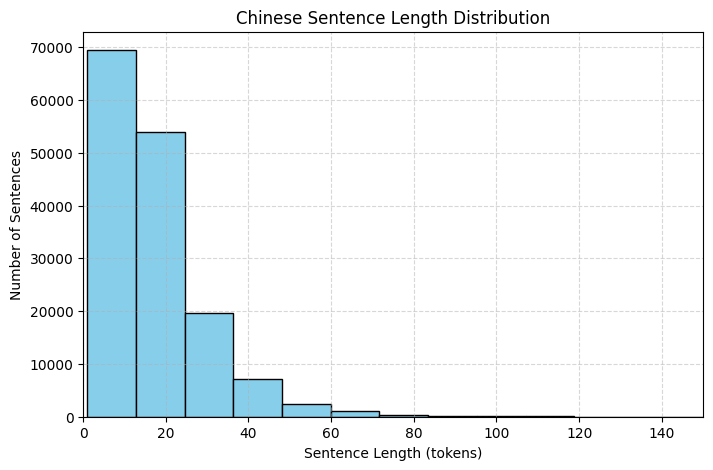

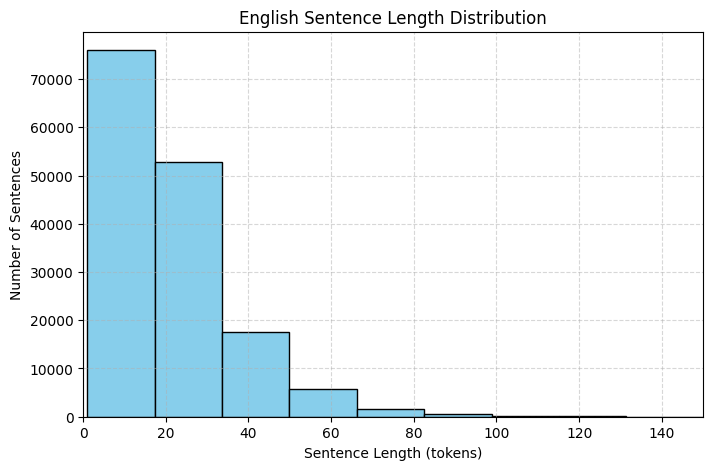

In [ ]:
def plot_length_histogram(lines, sp, language_name="src", bins=50):
    lengths = [len(sp.EncodeAsIds(line)) for line in lines]
    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'{language_name} Sentence Length Distribution')
    plt.xlabel('Sentence Length (tokens)')
    plt.ylabel('Number of Sentences')
    plt.xlim(0, 150)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_length_histogram(zh_sentences, sp_zh, "Chinese")
plot_length_histogram(en_sentences, sp_en, "English")

# 创建训练集

In [ ]:
MAX_LEN = 60  # 设定源和目标序列的最大长度

class TranslationDataset(Dataset):  # 继承 PyTorch 的 Dataset 类
    def __init__(self, src_lines, tgt_lines, sp_src, sp_tgt, max_len=MAX_LEN):
        """
        初始化数据集
        :param src_lines: 源语言句子列表（中文）
        :param tgt_lines: 目标语言句子列表（英文）
        :param sp_src: 源语言的 SentencePiece 分词器
        :param sp_tgt: 目标语言的 SentencePiece 分词器
        :param max_len: 最大句子长度（默认60）
        """
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.sp_src = sp_src
        self.sp_tgt = sp_tgt
        self.max_len = max_len

    def __len__(self):
        # 返回数据集中样本的数量
        return len(self.src_lines)

    def __getitem__(self, idx):
        """
        获取第 idx 个样本，并将其转换为定长的 token id 序列
        :return: 一个字典，包含 "src_ids" 和 "tgt_ids"，都是张量
        """
        # 将源语言句子编码成 token ids，截断至 max_len-2 是为了给句子起始符和句子结束符留空间
        src_ids = self.sp_src.EncodeAsIds(self.src_lines[idx])[:self.max_len - 2]
        # 同理，编码目标语言句子
        tgt_ids = self.sp_tgt.EncodeAsIds(self.tgt_lines[idx])[:self.max_len - 2]

        # 添加 BOS（句子起始符）和 EOS（句子结束符）
        src = [self.sp_src.bos_id()] + src_ids + [self.sp_src.eos_id()]
        tgt = [self.sp_tgt.bos_id()] + tgt_ids + [self.sp_tgt.eos_id()]

        # 用 0（表示 <PAD>）进行填充，使长度达到 max_len
        src += [0] * (self.max_len - len(src))
        tgt += [0] * (self.max_len - len(tgt))

        return {
            "src_ids": torch.tensor(src, dtype=torch.long),  # 源语言 token id 序列
            "tgt_ids": torch.tensor(tgt, dtype=torch.long)   # 目标语言 token id 序列
        }


In [ ]:
dataset = TranslationDataset(zh_sentences, en_sentences, sp_zh, sp_en)
train_size = int(len(dataset) * 0.9) # 90%训练集
valid_size = len(dataset) - train_size # 10%验证集
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=256, num_workers=12)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Transformer模型搭建

## 位置编码

$$
\begin{aligned}
PE_{(pos,\ 2i)}   &= \sin\left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right) \\
\\
PE_{(pos,\ 2i+1)} &= \cos\left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
\end{aligned}
$$

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000): # d_model: 表示 token 的嵌入维度；max_len: 允许的位置编码的最大长度
        super().__init__()
        pe = torch.zeros(max_len, d_model) # 创建 [max_len, d_model] 的空位置编码矩阵
        position = torch.arange(0, max_len).unsqueeze(1).float() # 生成 [max_len, 1] 的位置索引：0~max_len-1
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # 控制不同维度的频率变化，shape: [d_model/2]
        pe[:, 0::2] = torch.sin(position * div_term) # 偶数位置用 sin
        pe[:, 1::2] = torch.cos(position * div_term) # 奇数位置用 cos
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)] # 将前 len(x) 的位置编码加到 x 上
        return x


## 定义Transformer 模型类

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size,
                 d_model=512, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super().__init__()

        # 词嵌入层：将 token id 映射为向量，padding_idx=0 表示忽略 PAD
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=0)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=0)

        # 位置编码：添加序列位置信息
        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_decoder = PositionalEncoding(d_model)

        # Transformer 编码器+解码器主体
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        # 输出层：将 transformer 输出映射为目标词表大小的 logits
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

        # 保存 d_model，用于缩放 embedding
        self.d_model = d_model

    def forward(self, src, tgt):
        """
        前向传播：
        src, tgt: [batch_size, seq_len]，输入和输出的 token ID 序列
        """
        # 构造 mask
        src_mask = self._generate_padding_mask(src)  # [batch_size, src_len]
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)  # [tgt_len, tgt_len]
        tgt_padding_mask = self._generate_padding_mask(tgt)  # [batch_size, tgt_len]

        # 词嵌入 + 位置编码，并乘以 √d_model
        src_emb = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.d_model))  # [batch, src_len, d_model]
        tgt_emb = self.pos_decoder(self.tgt_embedding(tgt) * math.sqrt(self.d_model))  # [batch, tgt_len, d_model]

        # 调整为 [seq_len, batch, d_model] 以符合 PyTorch Transformer API
        src_emb = src_emb.transpose(0, 1)
        tgt_emb = tgt_emb.transpose(0, 1)

        # 输入 transformer 模型
        output = self.transformer(
            src_emb, tgt_emb,
            src_key_padding_mask=src_mask,          # 忽略 src 中的 PAD token
            tgt_mask=tgt_mask,                      # 强制自回归（防止看到后面的词）
            tgt_key_padding_mask=tgt_padding_mask   # 忽略 tgt 中的 PAD token
        )

        # 输出维度从 [seq_len, batch, d_model] → [seq_len, batch, vocab_size]
        output = self.fc_out(output)

        # 转回 [batch, seq_len, vocab_size] 以便后续 loss 或 softmax
        return output.transpose(0, 1)

    def _generate_square_subsequent_mask(self, sz):
        """
        生成解码器的上三角 mask，防止模型看到未来的信息（自回归）
        结果是 [sz, sz] 的矩阵，下三角为 0，上三角为 -inf
        """
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def _generate_padding_mask(self, seq):
        """
        为源或目标序列生成 padding mask
        输入: [batch_size, seq_len]
        输出: [batch_size, seq_len]（True 表示是 PAD，需要 mask 掉）
        """
        return (seq == 0)


# Label smoothing 损失函数

In [10]:
def label_smoothed_nll_loss(logits, target, eps=0.1, ignore_index=0):
    n_class = logits.size(-1)
    log_probs = F.log_softmax(logits, dim=-1)
    loss = -log_probs.gather(dim=-1, index=target.unsqueeze(-1)).squeeze(-1)
    smooth_loss = -log_probs.mean(dim=-1)

    mask = target != ignore_index
    loss = loss[mask]
    smooth_loss = smooth_loss[mask]

    return (1.0 - eps) * loss.mean() + eps * smooth_loss.mean()


# Noam学习率调度器

In [11]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self._step = 0

    def step(self):
        self._step += 1
        lr = self.d_model ** (-0.5) * min(self._step ** (-0.5), self._step * self.warmup_steps ** (-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr


# 训练函数

In [ ]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()  # 设置为评估模式

    total_loss = 0     # 累积总损失
    correct = 0        # 预测正确的 token 数
    total = 0          # 有效（非 PAD）token 总数

    with torch.no_grad():  # 评估过程中不计算梯度，节省显存
        for batch in dataloader:
            # 从 batch 中取出源语言和目标语言的 token 序列
            src = batch["src_ids"].to(device)  # [batch_size, src_len]
            tgt = batch["tgt_ids"].to(device)  # [batch_size, tgt_len]

            # 解码器输入是去掉最后一个 token 的目标序列
            tgt_input = tgt[:, :-1]  # [batch_size, tgt_len - 1]
            # 解码器预测的目标是下一个 token，即从第一个 token 开始
            tgt_output = tgt[:, 1:]  # [batch_size, tgt_len - 1]

            # 模型输出 logits（未归一化得分）
            logits = model(src, tgt_input)  # [batch_size, tgt_len - 1, vocab_size]
            # 将 logits 和目标展平成二维，用于计算损失
            logits = logits.reshape(-1, logits.size(-1))         # [batch * tgt_len, vocab_size]
            tgt_output = tgt_output.reshape(-1)                  # [batch * tgt_len]

            # 计算损失
            loss = criterion(logits, tgt_output)

            total_loss += loss.item()  # 累积损失

            # 预测类别：取 logit 最大值对应的词 ID
            preds = logits.argmax(dim=-1)  # [batch * tgt_len]

            # 创建 mask，忽略 PAD token 的位置（通常 PAD = 0）
            mask = tgt_output != 0  # [batch * tgt_len]

            # 统计预测正确的 token 数
            correct += (preds == tgt_output)[mask].sum().item()
            # 统计非 PAD 的 token 总数
            total += mask.sum().item()

    # 平均损失 = 总损失 / batch 数
    avg_loss = total_loss / len(dataloader)

    # 精度 = 正确预测的 token 数 / 有效 token 总数
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy


In [ ]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, scheduler, epochs=30, device='cuda'):
    import warnings
    warnings.filterwarnings("ignore")  # 忽略警告

    model.train()  # 设置模型为训练模式

    # 用于记录每轮训练/验证的损失和精度
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []

    for epoch in range(epochs):
        model.train()  # 每轮开始前确保处于训练模式
        epoch_loss = 0  # 当前 epoch 的损失累计
        correct = 0     # 当前 epoch 中预测正确的 token 数
        total = 0       # 当前 epoch 中所有非 PAD 的 token 数

        # === 遍历训练数据 ===
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            src = batch["src_ids"].to(device)  # 源语言输入序列
            tgt = batch["tgt_ids"].to(device)  # 目标语言输出序列

            # 解码器输入和目标：错位一位（teacher forcing）
            tgt_input = tgt[:, :-1]   # 去掉末尾 token（输入）
            tgt_output = tgt[:, 1:]   # 去掉起始 token（目标）

            # 前向传播：获取 logits 结果
            logits = model(src, tgt_input)  # 输出 [batch_size, tgt_len-1, vocab_size]
            logits = logits.reshape(-1, logits.size(-1))      # 展平成 [batch * tgt_len, vocab_size]
            tgt_output = tgt_output.reshape(-1)               # 展平成 [batch * tgt_len]

            # 计算损失
            loss = criterion(logits, tgt_output)

            # 反向传播与参数更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()  # 更新学习率（Noam）

            # 记录损失
            epoch_loss += loss.item()

            # 预测 token 并计算准确率
            preds = logits.argmax(dim=-1)           # [batch * tgt_len]
            mask = tgt_output != 0                  # 忽略 PAD 部分
            correct += (preds == tgt_output)[mask].sum().item()
            total += mask.sum().item()

        # 计算当前 epoch 的训练平均损失和准确率
        train_avg_loss = epoch_loss / len(train_loader)
        train_acc = correct / total if total > 0 else 0

        # 保存训练集结果
        train_loss_history.append(train_avg_loss)
        train_acc_history.append(train_acc)

        # === 在验证集上评估当前模型性能 ===
        valid_loss, valid_acc = evaluate_model(model, valid_loader, criterion, device)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # 打印当前 epoch 的训练和验证结果
        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_avg_loss:.4f} | Train Acc: {train_acc:.4f} || "
              f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

    # 返回每轮的训练/验证损失和精度历史
    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


# 模型训练与评估

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time

Epoch 1/50 Train Loss: 6.9779 | Train Acc: 0.1495 || Valid Loss: 5.9310 | Valid Acc: 0.2248


Epoch 2/50 Train Loss: 5.7215 | Train Acc: 0.2396 || Valid Loss: 5.4751 | Valid Acc: 0.2614


Epoch 3/50 Train Loss: 5.3783 | Train Acc: 0.2670 || Valid Loss: 5.2101 | Valid Acc: 0.2854


Epoch 4/50 Train Loss: 5.1271 | Train Acc: 0.2890 || Valid Loss: 5.0017 | Valid Acc: 0.3052


Epoch 5/50 Train Loss: 4.9029 | Train Acc: 0.3092 || Valid Loss: 4.8296 | Valid Acc: 0.3202


Epoch 6/50 Train Loss: 4.6887 | Train Acc: 0.3303 || Valid Loss: 4.6878 | Valid Acc: 0.3315


Epoch 7/50 Train Loss: 4.5028 | Train Acc: 0.3479 || Valid Loss: 4.5469 | Valid Acc: 0.3512


Epoch 8/50 Train Loss: 4.3464 | Train Acc: 0.3640 || Valid Loss: 4.4417 | Valid Acc: 0.3633


Epoch 9/50 Train Loss: 4.1683 | Train Acc: 0.3844 || Valid Loss: 4.3568 | Valid Acc: 0.3749


Epoch 10/50 Train Loss: 4.0062 | Train Acc: 0.4044 || Valid Loss: 4.2802 | Valid Acc: 0.3878


Epoch 11/50 Train Loss: 3.8626 | Train Acc: 0.4234 || Valid Loss: 4.2383 | Valid Acc: 0.3951


Epoch 12/50 Train Loss: 3.7346 | Train Acc: 0.4414 || Valid Loss: 4.2297 | Valid Acc: 0.3949


Epoch 13/50 Train Loss: 3.6149 | Train Acc: 0.4597 || Valid Loss: 4.2202 | Valid Acc: 0.4010


Epoch 14/50 Train Loss: 3.5064 | Train Acc: 0.4769 || Valid Loss: 4.2273 | Valid Acc: 0.4013


Epoch 15/50 Train Loss: 3.4067 | Train Acc: 0.4937 || Valid Loss: 4.2228 | Valid Acc: 0.4048


Epoch 16/50 Train Loss: 3.3139 | Train Acc: 0.5101 || Valid Loss: 4.2516 | Valid Acc: 0.4040


Epoch 17/50 Train Loss: 3.2276 | Train Acc: 0.5259 || Valid Loss: 4.2629 | Valid Acc: 0.4066


Epoch 18/50 Train Loss: 3.1470 | Train Acc: 0.5412 || Valid Loss: 4.3000 | Valid Acc: 0.4041


Epoch 19/50 Train Loss: 3.0718 | Train Acc: 0.5560 || Valid Loss: 4.3217 | Valid Acc: 0.4055


Epoch 20/50 Train Loss: 3.0016 | Train Acc: 0.5702 || Valid Loss: 4.3548 | Valid Acc: 0.4010


Epoch 21/50 Train Loss: 2.9376 | Train Acc: 0.5836 || Valid Loss: 4.3840 | Valid Acc: 0.4007


Epoch 22/50 Train Loss: 2.8762 | Train Acc: 0.5972 || Valid Loss: 4.4201 | Valid Acc: 0.4020


Epoch 23/50 Train Loss: 2.8197 | Train Acc: 0.6095 || Valid Loss: 4.4490 | Valid Acc: 0.4011


Epoch 24/50 Train Loss: 2.7650 | Train Acc: 0.6221 || Valid Loss: 4.4807 | Valid Acc: 0.3993


Epoch 25/50 Train Loss: 2.7149 | Train Acc: 0.6333 || Valid Loss: 4.5178 | Valid Acc: 0.3960


Epoch 26/50 Train Loss: 2.6658 | Train Acc: 0.6451 || Valid Loss: 4.5507 | Valid Acc: 0.3967


Epoch 27/50 Train Loss: 2.6209 | Train Acc: 0.6561 || Valid Loss: 4.5873 | Valid Acc: 0.3932


Epoch 28/50 Train Loss: 2.5782 | Train Acc: 0.6664 || Valid Loss: 4.6405 | Valid Acc: 0.3894


Epoch 29/50 Train Loss: 2.5385 | Train Acc: 0.6765 || Valid Loss: 4.6447 | Valid Acc: 0.3940


Epoch 30/50 Train Loss: 2.5013 | Train Acc: 0.6860 || Valid Loss: 4.6961 | Valid Acc: 0.3886


Epoch 31/50 Train Loss: 2.4651 | Train Acc: 0.6955 || Valid Loss: 4.7299 | Valid Acc: 0.3893


Epoch 32/50 Train Loss: 2.4304 | Train Acc: 0.7043 || Valid Loss: 4.7490 | Valid Acc: 0.3882


Epoch 33/50 Train Loss: 2.3981 | Train Acc: 0.7130 || Valid Loss: 4.7868 | Valid Acc: 0.3874


Epoch 34/50 Train Loss: 2.3664 | Train Acc: 0.7215 || Valid Loss: 4.8068 | Valid Acc: 0.3864


Epoch 35/50 Train Loss: 2.3375 | Train Acc: 0.7297 || Valid Loss: 4.8471 | Valid Acc: 0.3844


Epoch 36/50 Train Loss: 2.3099 | Train Acc: 0.7374 || Valid Loss: 4.8598 | Valid Acc: 0.3858


Epoch 37/50 Train Loss: 2.2844 | Train Acc: 0.7445 || Valid Loss: 4.9061 | Valid Acc: 0.3811


Epoch 38/50 Train Loss: 2.2590 | Train Acc: 0.7520 || Valid Loss: 4.9285 | Valid Acc: 0.3806


Epoch 39/50 Train Loss: 2.2390 | Train Acc: 0.7575 || Valid Loss: 4.9417 | Valid Acc: 0.3808


Epoch 40/50 Train Loss: 2.2145 | Train Acc: 0.7648 || Valid Loss: 4.9665 | Valid Acc: 0.3814


Epoch 41/50 Train Loss: 2.1938 | Train Acc: 0.7708 || Valid Loss: 4.9934 | Valid Acc: 0.3793


Epoch 42/50 Train Loss: 2.1723 | Train Acc: 0.7773 || Valid Loss: 5.0345 | Valid Acc: 0.3784


Epoch 43/50 Train Loss: 2.1528 | Train Acc: 0.7833 || Valid Loss: 5.0376 | Valid Acc: 0.3809


Epoch 44/50 Train Loss: 2.1334 | Train Acc: 0.7892 || Valid Loss: 5.0783 | Valid Acc: 0.3764


Epoch 45/50 Train Loss: 2.1167 | Train Acc: 0.7942 || Valid Loss: 5.0672 | Valid Acc: 0.3779


Epoch 46/50 Train Loss: 2.0981 | Train Acc: 0.8003 || Valid Loss: 5.0952 | Valid Acc: 0.3775


Epoch 47/50 Train Loss: 2.0830 | Train Acc: 0.8049 || Valid Loss: 5.1416 | Valid Acc: 0.3752


Epoch 48/50 Train Loss: 2.0668 | Train Acc: 0.8098 || Valid Loss: 5.1266 | Valid Acc: 0.3767


Epoch 49/50 Train Loss: 2.0525 | Train Acc: 0.8142 || Valid Loss: 5.1760 | Valid Acc: 0.3739


Epoch 50/50 Train Loss: 2.0386 | Train Acc: 0.8187 || Valid Loss: 5.1789 | Valid Acc: 0.3753
Total training time: 10070.17 seconds


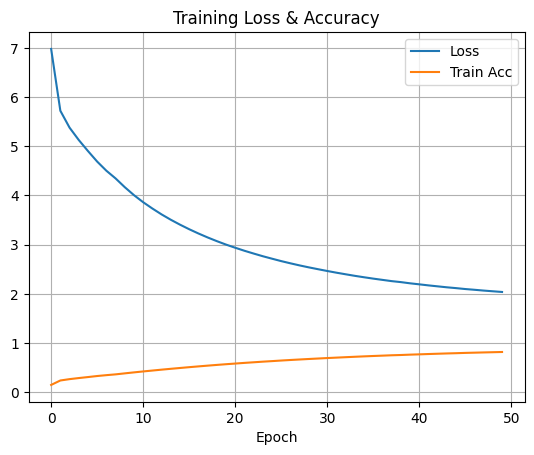

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

src_vocab_size = len(sp_zh)
tgt_vocab_size = len(sp_en)

model = TransformerModel(src_vocab_size, tgt_vocab_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
criterion = label_smoothed_nll_loss
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000)

start_time = time.time()  # 记录训练开始时间
train_losses, train_accs, valid_losses, valid_accs = train_model(model, train_loader, valid_loader, optimizer, criterion, scheduler, epochs=50)
end_time = time.time()  # 训练结束时间
total_time = end_time - start_time  # 计算训练总耗时（秒）
print(f"Total training time: {total_time:.2f} seconds")

plt.plot(train_losses, label='Loss')
plt.plot(train_accs, label='Train Acc')
plt.xlabel("Epoch")
plt.title("Training Loss & Accuracy")
plt.legend()
plt.grid(True)
plt.show()


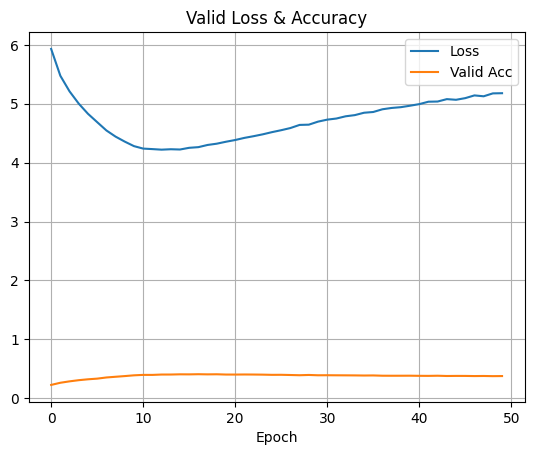

In [ ]:
plt.plot(valid_losses, label='Loss')
plt.plot(valid_accs, label='Valid Acc')
plt.xlabel("Epoch")
plt.title("Valid Loss & Accuracy")
plt.legend()
plt.grid(True)
plt.show()

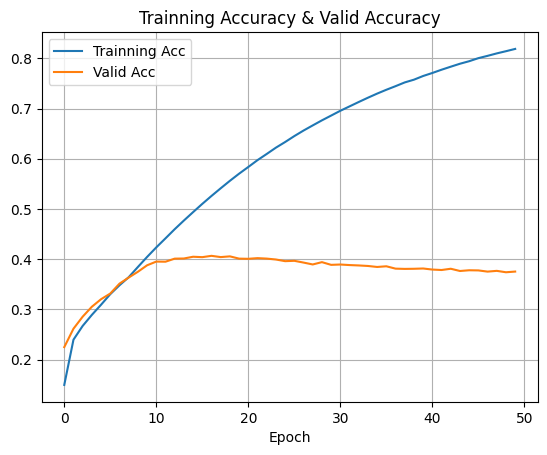

In [ ]:
plt.plot(train_accs, label='Trainning Acc')
plt.plot(valid_accs, label='Valid Acc')
plt.xlabel("Epoch")
plt.title("Trainning Accuracy & Valid Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 保存模型状态字典
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_step': scheduler._step,
    'train_losses': train_losses,
    'train_accs': train_accs,
}, "transformer_translation.pt")

print("模型已保存为 transformer_translation.pt")


模型已保存为 transformer_translation.pt


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_vocab_size = len(sp_zh)
tgt_vocab_size = len(sp_en)
model = TransformerModel(src_vocab_size, tgt_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
criterion = label_smoothed_nll_loss
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000)

# 加载模型
checkpoint = torch.load("transformer_translation.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler._step = checkpoint['scheduler_step']  # 恢复Noam的step
train_losses = checkpoint['train_losses']
train_accs = checkpoint['train_accs']

print("模型和优化器状态已恢复")

d:\anaconda3\envs\DL\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\Peng\AppData\Local\Temp\ipykernel_21856\391847875.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

模型和优化器状态已恢复


# 翻译测试

In [ ]:
# Greedy search
def translate(model, sp_src, sp_tgt, sentence, max_len=60, device='cuda'):
    model.eval()
    src_ids = sp_src.EncodeAsIds(sentence)[:max_len-2]
    src_ids = [1] + src_ids + [2]
    src_ids += [0] * (max_len - len(src_ids))
    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)

    tgt_ids = [1]
    for i in range(max_len):
        tgt = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(src, tgt)
        next_token = output[0, -1].argmax().item()
        tgt_ids.append(next_token)
        if next_token == 2:  # EOS
            break
    return sp_tgt.DecodeIds(tgt_ids[1:-1])


## 训练集样本内翻译测试

In [ ]:
print(translate(model, sp_zh, sp_en, "海洋是一个非常复杂的事物。", device=device))

It can be a very complicated thing, the ocean.


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print(translate(model, sp_zh, sp_en, "人类的健康也是一件非常复杂的事情。", device=device))

And it could be a complicated thing, what human health is.


In [ ]:
sentence = "将两者统一起来看起来是一件艰巨的任务。但我想要试图去说明的是 即使是如此复杂的情况，\
       也存在一些我认为简单的话题， 一些如果我们能理解，就很容易向前发展的话题。"

print(translate(model, sp_zh, sp_en, sentence, device=device))

What I'm going to try to say, even though I think that even though we can make those two very complicated objects that just seem a very simple task, it's actually going to be a challenge, but it's a very simple reason to move forward.


In [ ]:
sentence = "这些简单的话题确实不是 有关那复杂的科学有了怎样的发展， 而是一些我们都恰好知道的事情。"

print(translate(model, sp_zh, sp_en, sentence, device=device))

And those simple themes aren't really themes about what we're going to say about, but it's a complicated topic that we've all pretty much learned.


## 训练集样本外翻译测试

In [ ]:
print(translate(model, sp_zh, sp_en, "你好，世界！", device=device))

Hello, avatar.


In [ ]:
print(translate(model, sp_zh, sp_en, "我爱深度学习！", device=device))

I love being able to learn that depth.


In [ ]:
print(translate(model, sp_zh, sp_en, "生活就像海洋，只有意志坚强的人才能到达彼岸", device=device))

Mults like living is a near-death Sci for life, where people to get their way.


In [ ]:
print(translate(model, sp_zh, sp_en, "生活不止眼前的苟且，还有诗和远方", device=device))

A life-song tear on and on and on, without us.


# 模型调参

In [ ]:
class TransformerModel_2(nn.Module): #dropout提升至0.2，解码层和编码层减少至4
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=2048, dropout=0.2):
        super().__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=0)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_decoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead,
                                          num_encoder_layers, num_decoder_layers,
                                          dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model

    def forward(self, src, tgt):
        # src, tgt shape: [batch_size, seq_len]
        src_mask = self._generate_padding_mask(src)
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        tgt_padding_mask = self._generate_padding_mask(tgt)

        src_emb = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_decoder(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        output = self.transformer(src_emb.transpose(0,1), tgt_emb.transpose(0,1),
                                  src_key_padding_mask=src_mask,
                                  tgt_mask=tgt_mask,
                                  tgt_key_padding_mask=tgt_padding_mask)
        output = self.fc_out(output)  # [seq_len, batch, tgt_vocab_size]
        return output.transpose(0,1)  # [batch, seq_len, tgt_vocab_size]

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def _generate_padding_mask(self, seq):
        return (seq == 0)

In [ ]:
class NoamScheduler_2: # warmup_steps提升至8000
    def __init__(self, optimizer, d_model, warmup_steps=8000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self._step = 0

    def step(self):
        self._step += 1
        lr = self.d_model ** (-0.5) * min(self._step ** (-0.5), self._step * self.warmup_steps ** (-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

In [ ]:
# 训练函数引入earlystop早停机制
def train_model_2(model, train_loader, valid_loader, optimizer, criterion, scheduler, epochs=30, device='cuda'):
    import warnings
    warnings.filterwarnings("ignore")

    model.train()
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            src = batch["src_ids"].to(device)
            tgt = batch["tgt_ids"].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            logits = model(src, tgt_input)
            logits = logits.reshape(-1, logits.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(logits, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

            preds = logits.argmax(dim=-1)
            mask = tgt_output != 0
            correct += (preds == tgt_output)[mask].sum().item()
            total += mask.sum().item()

        train_avg_loss = epoch_loss / len(train_loader)
        train_acc = correct / total if total > 0 else 0
        train_loss_history.append(train_avg_loss)
        train_acc_history.append(train_acc)

        # === 验证集评估 ===
        valid_loss, valid_acc = evaluate_model(model, valid_loader, criterion, device)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)
        best_acc = 0
        if valid_acc > best_acc:
            best_acc = valid_acc
            counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("✅ 保存新最佳模型")
        else:
            counter += 1
            patience = 5 #耐心参数设置为3
            if counter >= patience:
                print("⛔ Early stopping")
                break

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_avg_loss:.4f} | Train Acc: {train_acc:.4f} || "
              f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


In [ ]:
model2 = TransformerModel_2(src_vocab_size, tgt_vocab_size).to(device)

In [ ]:
optimizer = torch.optim.Adam(model2.parameters(), betas=(0.9, 0.98), eps=1e-9)
criterion = label_smoothed_nll_loss
scheduler = NoamScheduler_2(optimizer, d_model=512, warmup_steps=8000)

start_time = time.time()  # 记录训练开始时间
train2_losses, train2_accs, valid2_losses, valid2_accs = train_model_2(model2, train_loader, valid_loader, optimizer, criterion, scheduler, epochs=50)
end_time = time.time()  # 训练结束时间
total_time = end_time - start_time  # 计算训练总耗时（秒）
print(f"Total training time: {total_time:.2f} seconds")


✅ 保存新最佳模型
Epoch 1/50 Train Loss: 7.5295 | Train Acc: 0.1204 || Valid Loss: 6.4204 | Valid Acc: 0.1815


✅ 保存新最佳模型
Epoch 2/50 Train Loss: 6.1352 | Train Acc: 0.2057 || Valid Loss: 5.8727 | Valid Acc: 0.2287


✅ 保存新最佳模型
Epoch 3/50 Train Loss: 5.7740 | Train Acc: 0.2340 || Valid Loss: 5.5989 | Valid Acc: 0.2531


✅ 保存新最佳模型
Epoch 4/50 Train Loss: 5.5468 | Train Acc: 0.2527 || Valid Loss: 5.4015 | Valid Acc: 0.2686


✅ 保存新最佳模型
Epoch 5/50 Train Loss: 5.3606 | Train Acc: 0.2681 || Valid Loss: 5.2375 | Valid Acc: 0.2829


✅ 保存新最佳模型
Epoch 6/50 Train Loss: 5.1942 | Train Acc: 0.2817 || Valid Loss: 5.0903 | Valid Acc: 0.2951


✅ 保存新最佳模型
Epoch 7/50 Train Loss: 5.0386 | Train Acc: 0.2945 || Valid Loss: 4.9635 | Valid Acc: 0.3079


✅ 保存新最佳模型
Epoch 8/50 Train Loss: 4.8852 | Train Acc: 0.3080 || Valid Loss: 4.8418 | Valid Acc: 0.3187


✅ 保存新最佳模型
Epoch 9/50 Train Loss: 4.7384 | Train Acc: 0.3214 || Valid Loss: 4.7320 | Valid Acc: 0.3317


✅ 保存新最佳模型
Epoch 10/50 Train Loss: 4.6048 | Train Acc: 0.3337 || Valid Loss: 4.6519 | Valid Acc: 0.3398


✅ 保存新最佳模型
Epoch 11/50 Train Loss: 4.4848 | Train Acc: 0.3447 || Valid Loss: 4.5893 | Valid Acc: 0.3462


✅ 保存新最佳模型
Epoch 12/50 Train Loss: 4.3797 | Train Acc: 0.3550 || Valid Loss: 4.5452 | Valid Acc: 0.3504


✅ 保存新最佳模型
Epoch 13/50 Train Loss: 4.2862 | Train Acc: 0.3642 || Valid Loss: 4.4909 | Valid Acc: 0.3546


✅ 保存新最佳模型
Epoch 14/50 Train Loss: 4.2039 | Train Acc: 0.3729 || Valid Loss: 4.4638 | Valid Acc: 0.3608


✅ 保存新最佳模型
Epoch 15/50 Train Loss: 4.1296 | Train Acc: 0.3813 || Valid Loss: 4.4408 | Valid Acc: 0.3635


✅ 保存新最佳模型
Epoch 16/50 Train Loss: 4.0461 | Train Acc: 0.3914 || Valid Loss: 4.4020 | Valid Acc: 0.3718


✅ 保存新最佳模型
Epoch 17/50 Train Loss: 3.9591 | Train Acc: 0.4026 || Valid Loss: 4.3792 | Valid Acc: 0.3753


✅ 保存新最佳模型
Epoch 18/50 Train Loss: 3.8786 | Train Acc: 0.4132 || Valid Loss: 4.3672 | Valid Acc: 0.3767


✅ 保存新最佳模型
Epoch 19/50 Train Loss: 3.8047 | Train Acc: 0.4239 || Valid Loss: 4.3649 | Valid Acc: 0.3779


✅ 保存新最佳模型
Epoch 20/50 Train Loss: 3.7351 | Train Acc: 0.4340 || Valid Loss: 4.3675 | Valid Acc: 0.3791


✅ 保存新最佳模型
Epoch 21/50 Train Loss: 3.6721 | Train Acc: 0.4435 || Valid Loss: 4.3599 | Valid Acc: 0.3850


✅ 保存新最佳模型
Epoch 22/50 Train Loss: 3.6129 | Train Acc: 0.4527 || Valid Loss: 4.3651 | Valid Acc: 0.3814


✅ 保存新最佳模型
Epoch 23/50 Train Loss: 3.5567 | Train Acc: 0.4618 || Valid Loss: 4.3741 | Valid Acc: 0.3868


✅ 保存新最佳模型
Epoch 24/50 Train Loss: 3.5043 | Train Acc: 0.4706 || Valid Loss: 4.3886 | Valid Acc: 0.3858


✅ 保存新最佳模型
Epoch 25/50 Train Loss: 3.4577 | Train Acc: 0.4783 || Valid Loss: 4.4054 | Valid Acc: 0.3848


✅ 保存新最佳模型
Epoch 26/50 Train Loss: 3.4108 | Train Acc: 0.4868 || Valid Loss: 4.4058 | Valid Acc: 0.3870


✅ 保存新最佳模型
Epoch 27/50 Train Loss: 3.3664 | Train Acc: 0.4946 || Valid Loss: 4.4215 | Valid Acc: 0.3857


✅ 保存新最佳模型
Epoch 28/50 Train Loss: 3.3257 | Train Acc: 0.5019 || Valid Loss: 4.4462 | Valid Acc: 0.3834


✅ 保存新最佳模型
Epoch 29/50 Train Loss: 3.2865 | Train Acc: 0.5089 || Valid Loss: 4.4599 | Valid Acc: 0.3845


✅ 保存新最佳模型
Epoch 30/50 Train Loss: 3.2482 | Train Acc: 0.5160 || Valid Loss: 4.4773 | Valid Acc: 0.3826


✅ 保存新最佳模型
Epoch 31/50 Train Loss: 3.2133 | Train Acc: 0.5229 || Valid Loss: 4.5030 | Valid Acc: 0.3792


✅ 保存新最佳模型
Epoch 32/50 Train Loss: 3.1794 | Train Acc: 0.5293 || Valid Loss: 4.5137 | Valid Acc: 0.3807


✅ 保存新最佳模型
Epoch 33/50 Train Loss: 3.1466 | Train Acc: 0.5363 || Valid Loss: 4.5318 | Valid Acc: 0.3824


KeyboardInterrupt: 

In [ ]:
plt.plot(train2_accs, label='Trainning Acc')
plt.plot(valid2_accs, label='Valid Acc')
plt.xlabel("Epoch")
plt.title("Trainning Accuracy & Valid Accuracy")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'train2_accs' is not defined

In [ ]:
# 加载模型
model2 = TransformerModel_2(src_vocab_size, tgt_vocab_size).to(device)
model2.load_state_dict(torch.load("/content/drive/MyDrive/best_model.pt", map_location=device))

print("模型状态已恢复")

模型状态已恢复


## 训练集样本内翻译测试

In [ ]:
print(translate(model2, sp_zh, sp_en, "海洋是一个非常复杂的事物。", device=device))

The ocean is a very complex thing.


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print(translate(model2, sp_zh, sp_en, "人类的健康也是一件非常复杂的事情。", device=device))

It's a very complex thing.


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
sentence = "将两者统一起来看起来是一件艰巨的任务。但我想要试图去说明的是 即使是如此复杂的情况，\
       也存在一些我认为简单的话题， 一些如果我们能理解，就很容易向前发展的话题。"

print(translate(model2, sp_zh, sp_en, sentence, device=device))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


And I think it's important to understand that although we can understand the complexities of two, although we can understand it, it's a bit harder, but it's also a difficult task to understand.


In [ ]:
sentence = "这些简单的话题确实不是 有关那复杂的科学有了怎样的发展， 而是一些我们都恰好知道的事情。"

print(translate(model2, sp_zh, sp_en, sentence, device=device))

And these simple themes aren't really complex, but what we know about the complex science of what we're doing.


## 训练集样本外翻译测试

In [ ]:
print(translate(model2, sp_zh, sp_en, "你好，世界！", device=device))

Hello.


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print(translate(model2, sp_zh, sp_en, "我爱深度学习！", device=device))

I love learning.


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print(translate(model2, sp_zh, sp_en, "生活就像海洋，只有意志坚强的人才能到达彼岸", device=device))

It's the most powerful way to live, to live, to be able to live without the ocean.


In [ ]:
print(translate(model2, sp_zh, sp_en, "生活不止眼前的苟且，还有诗和远方", device=device))

Life and poetry are far away.


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


# 翻译函数优化

翻译时有三种token预测方式： greedy / beam search / top-k sampling

前文用的是greedy贪婪算法，接下来对beam search 和 top-k sampling算法进行尝试

In [15]:
import torch
import torch.nn.functional as F

In [16]:
def translate(model, sp_src, sp_tgt, sentence,
              max_len=60, device='cuda',
              mode='greedy', top_k=5, beam_width=3):
    model.eval()

    # 源句子编码 + 填充
    src_ids = [1] + sp_src.EncodeAsIds(sentence)[:max_len - 2] + [2]
    src_ids += [0] * (max_len - len(src_ids))
    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)

    # === greedy search ===
    if mode == 'greedy':
        tgt_ids = [1]
        for _ in range(max_len):
            tgt = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(src, tgt)
            next_token = output[0, -1].argmax().item()
            tgt_ids.append(next_token)
            if next_token == 2:
                break
        return sp_tgt.DecodeIds(tgt_ids[1:-1] if 2 in tgt_ids else tgt_ids[1:])

    # === top-k sampling ===
    elif mode == 'topk':
        tgt_ids = [1]
        for _ in range(max_len):
            tgt = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(src, tgt)
            logits = output[0, -1]
            topk_vals, topk_ids = torch.topk(logits, k=top_k)
            probs = F.softmax(topk_vals, dim=0)
            next_token = topk_ids[torch.multinomial(probs, 1)].item()
            tgt_ids.append(next_token)
            if next_token == 2:
                break
        return sp_tgt.DecodeIds(tgt_ids[1:-1] if 2 in tgt_ids else tgt_ids[1:])

    # === beam search ===
    elif mode == 'beam':
        beams = [([1], 0)]  # (token_ids, score)
        for _ in range(max_len):
            new_beams = []
            for seq, score in beams:
                if seq[-1] == 2:
                    new_beams.append((seq, score))
                    continue
                tgt = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(src, tgt)
                log_probs = F.log_softmax(output[0, -1], dim=-1)
                topk_vals, topk_ids = torch.topk(log_probs, k=beam_width)
                for log_p, token_id in zip(topk_vals, topk_ids):
                    new_seq = seq + [token_id.item()]
                    new_score = score + log_p.item()
                    new_beams.append((new_seq, new_score))
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            if all(seq[-1] == 2 for seq, _ in beams):
                break
        best_seq = beams[0][0]
        return sp_tgt.DecodeIds(best_seq[1:-1] if 2 in best_seq else best_seq[1:])

    else:
        raise ValueError(f"Unsupported mode: {mode}")


In [17]:
sp_src = sp_zh
sp_tgt = sp_en
translate(model, sp_src, sp_tgt, "我们可以见面吗？", mode='greedy')

d:\anaconda3\envs\DL\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


'Can we meet meet meet meet meet meet?'

In [ ]:
translate(model, sp_src, sp_tgt, "谢谢你！", mode='topk', top_k=8)

'Thank you.'

In [ ]:
translate(model, sp_src, sp_tgt, "世界的尽头是哪里？", mode='beam', beam_width=5)

"Where's the end of the world?"

## beam search

In [ ]:
translate(model, sp_zh, sp_en, "你好，世界！", mode='beam', beam_width=5)

'Hello, worlds!'

In [ ]:
translate(model, sp_zh, sp_en, "我爱深度学习！", mode='beam', beam_width=5)

'I love being able to learn that depth.'

In [ ]:
translate(model, sp_zh, sp_en, "生活就像海洋，只有意志坚强的人才能到达彼岸", mode='beam', beam_width=5)

'Normally, it was only going to be near-in-the-powerful to the ocean.'

In [ ]:
translate(model, sp_zh, sp_en, "生活不止眼前的苟且，还有诗和远方", mode='beam', beam_width=5)

'Allow your eyes and your life backy life.'

## top-k sampling

In [ ]:
translate(model, sp_src, sp_tgt, "你好，世界！", mode='topk', top_k=5)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


'Hello, worlds!'

In [ ]:
translate(model, sp_src, sp_tgt, "我爱深度学习！", mode='topk', top_k=5)

'I love being able to learn by such.'

In [ ]:
translate(model, sp_src, sp_tgt, "生活就像海洋，只有意志坚强的人才能到达彼岸", mode='topk', top_k=5)

'The ocean was only able to get to pretty late, so groups would be able to reach the ocean.'

In [ ]:
translate(model, sp_src, sp_tgt, "生活不止眼前的苟且，还有诗和远方", mode='topk', top_k=5)

'A psecong between my eyes and the cat.'

## BLEU评估

读取翻译样本集translation_samples，里面包含的句子类型有：

基础简单句，一般陈述句，否定句/时态，疑问句，连词 / 复合句，长句/学术类，歧义/需要语境

In [ ]:
#!pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 1.1 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.8 MB/s eta 0:00:00


In [20]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [22]:
# 读取制表符分隔的txt文件
translation_samples_path = "translation_samples.txt"
df = pd.read_csv(translation_samples_path, sep="\t", header=None, names=["zh", "en"], encoding="utf-8")

smooth_fn = SmoothingFunction().method1

In [23]:
def calc_bleu(reference, hypothesis):
    ref_tokens = reference.lower().split()
    hyp_tokens = hypothesis.lower().split()
    return sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth_fn)

modes = ["greedy", "beam", "topk"]
results = {mode: [] for mode in modes}

for mode in modes:
    for sent_zh, sent_en_ref in tqdm(zip(df["zh"], df["en"]), total=len(df)):
        pred_en = translate(model, sp_src, sp_tgt, sent_zh, mode=mode, top_k=5, beam_width=5)
        bleu = calc_bleu(sent_en_ref, pred_en)
        results[mode].append(bleu)

for mode in modes:
    avg_bleu = sum(results[mode]) / len(results[mode])
    print(f"Mode: {mode}, Avg BLEU: {avg_bleu:.4f}")

  0%|          | 0/21 [00:00<?, ?it/s]d:\anaconda3\envs\DL\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 21/21 [00:01<00:00, 13.60it/s]

Mode: greedy, Avg BLEU: 0.1630
Mode: beam, Avg BLEU: 0.2050
Mode: topk, Avg BLEU: 0.0476


/tmp/ipython-input-84-1266909311.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[m] for m in modes], labels=modes)


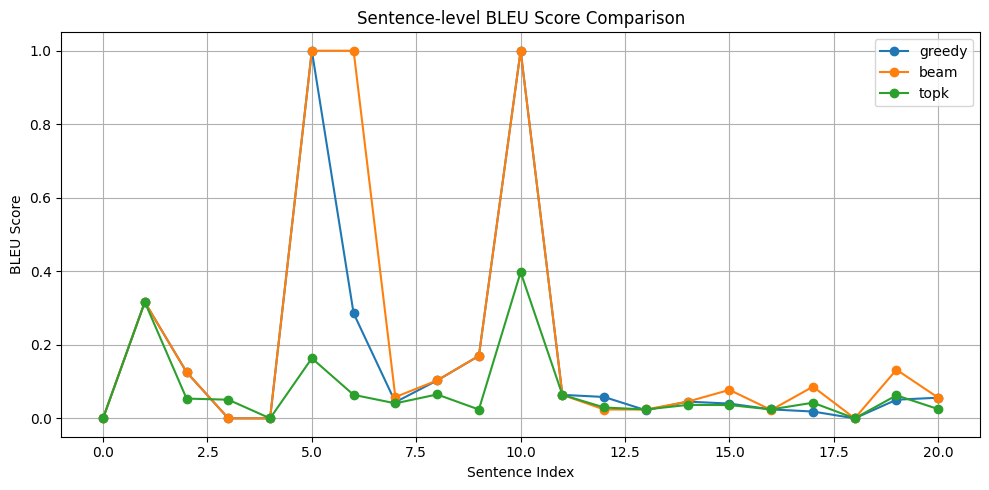

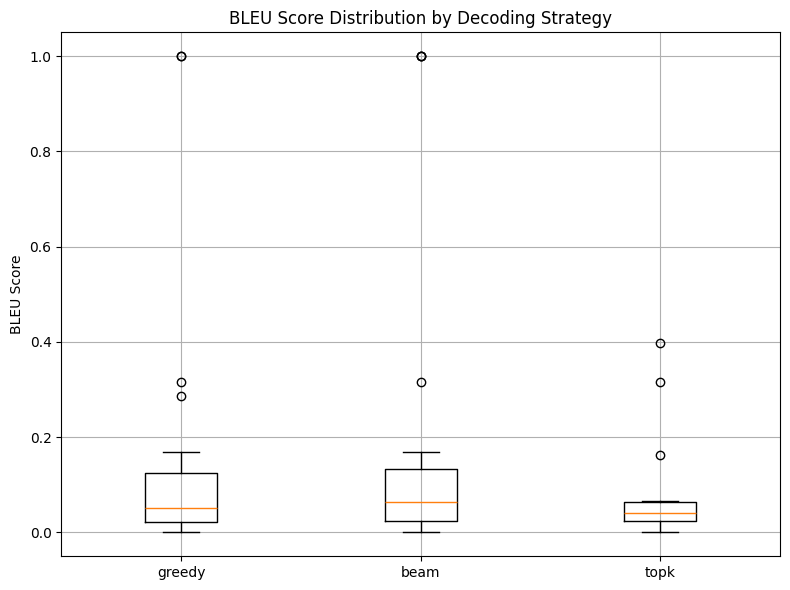

In [ ]:
plt.figure(figsize=(10, 5))
for mode in modes:
    plt.plot(range(len(results[mode])), results[mode], label=mode, marker='o')
plt.title("Sentence-level BLEU Score Comparison")
plt.xlabel("Sentence Index")
plt.ylabel("BLEU Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bleu_trend.png")

# 箱线图：BLEU 分布
plt.figure(figsize=(8, 6))
plt.boxplot([results[m] for m in modes], labels=modes)
plt.title("BLEU Score Distribution by Decoding Strategy")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("bleu_boxplot.png")

## beam search和top-k sampling优化

In [31]:
# ==== 设置 Beam Width 范围 ====
beam_range = list(range(3, 13))  # Beam Width = 3 到 12
beam_bleu_scores = {bw: [] for bw in beam_range}

# ==== 执行翻译 + BLEU 评估 ====
for bw in beam_range:
    print(f"\n📌 Evaluating beam_width = {bw}")
    for zh, en_ref in tqdm(zip(df["zh"], df["en"]), total=len(df), desc=f"Beam {bw}"):
        pred = translate(model, sp_src, sp_tgt, zh, mode="beam", beam_width=bw)
        bleu = calc_bleu(en_ref, pred)
        beam_bleu_scores[bw].append(bleu)

# ==== 计算平均 BLEU 分数 ====
beam_avg_bleus = [sum(beam_bleu_scores[bw]) / len(beam_bleu_scores[bw]) for bw in beam_range]

# ==== 打印结果 ====
for bw, bleu in zip(beam_range, beam_avg_bleus):
    print(f"Beam width {bw} → Avg BLEU: {bleu:.4f}")


📌 Evaluating beam_width = 3


Beam 3:   0%|          | 0/21 [00:00<?, ?it/s]d:\anaconda3\envs\DL\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Beam 3: 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]



📌 Evaluating beam_width = 4


Beam 4: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]



📌 Evaluating beam_width = 5


Beam 5: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]



📌 Evaluating beam_width = 6


Beam 6: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]



📌 Evaluating beam_width = 7


Beam 7: 100%|██████████| 21/21 [00:10<00:00,  1.92it/s]



📌 Evaluating beam_width = 8


Beam 8: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]



📌 Evaluating beam_width = 9


Beam 9: 100%|██████████| 21/21 [00:14<00:00,  1.45it/s]



📌 Evaluating beam_width = 10


Beam 10: 100%|██████████| 21/21 [00:16<00:00,  1.24it/s]



📌 Evaluating beam_width = 11


Beam 11: 100%|██████████| 21/21 [00:18<00:00,  1.15it/s]



📌 Evaluating beam_width = 12


Beam 12: 100%|██████████| 21/21 [00:19<00:00,  1.08it/s]

Beam width 3 → Avg BLEU: 0.1994
Beam width 4 → Avg BLEU: 0.2038
Beam width 5 → Avg BLEU: 0.2050
Beam width 6 → Avg BLEU: 0.2050
Beam width 7 → Avg BLEU: 0.2050
Beam width 8 → Avg BLEU: 0.2052
Beam width 9 → Avg BLEU: 0.2052
Beam width 10 → Avg BLEU: 0.2052
Beam width 11 → Avg BLEU: 0.2052
Beam width 12 → Avg BLEU: 0.2052


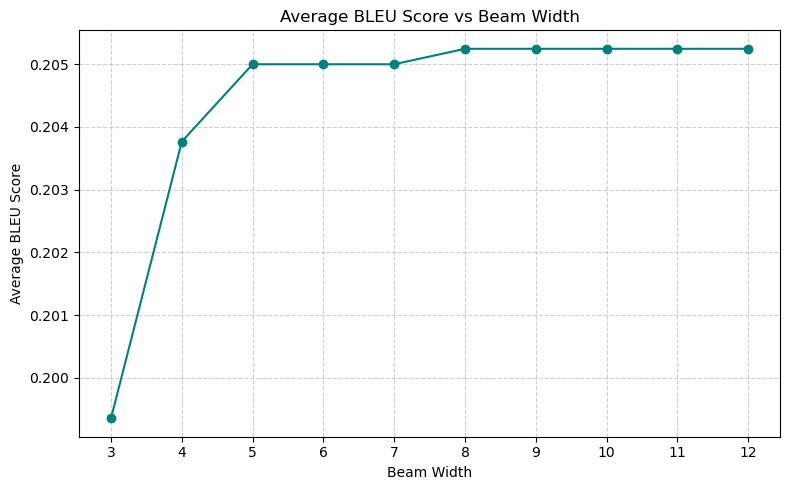

In [32]:
# ==== 可视化 BLEU vs beam_width ====
plt.figure(figsize=(8, 5))
plt.plot(beam_range, beam_avg_bleus, marker='o', linestyle='-', color='teal')
plt.title("Average BLEU Score vs Beam Width")
plt.xlabel("Beam Width")
plt.ylabel("Average BLEU Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(beam_range)
plt.tight_layout()
plt.savefig("beam_bleu_curve.png")
plt.show()

In [33]:
# ==== 设置 top-k 范围 ====
topk_range = list(range(3, 13))  # top-k = 3 到 12
topk_bleu_scores = {k: [] for k in topk_range}

# ==== 执行翻译 + BLEU 评估 ====
for k in topk_range:
    print(f"\n📌 Evaluating top_k = {k}")
    for zh, en_ref in tqdm(zip(df["zh"], df["en"]), total=len(df), desc=f"Top-k {k}"):
        pred = translate(model, sp_src, sp_tgt, zh, mode="topk", top_k=k)
        bleu = calc_bleu(en_ref, pred)
        topk_bleu_scores[k].append(bleu)

# ==== 计算平均 BLEU 分数 ====
topk_bleu_scores = [sum(topk_bleu_scores[k]) / len(topk_bleu_scores[k]) for k in topk_range]

# ==== 打印结果 ====
for k, bleu in zip(topk_range, topk_bleu_scores):
    print(f"Top-k {k} → Avg BLEU: {bleu:.4f}")



📌 Evaluating top_k = 3


Top-k 3:   0%|          | 0/21 [00:00<?, ?it/s]d:\anaconda3\envs\DL\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Top-k 3: 100%|██████████| 21/21 [00:01<00:00, 11.53it/s]



📌 Evaluating top_k = 4


Top-k 4: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]



📌 Evaluating top_k = 5


Top-k 5: 100%|██████████| 21/21 [00:01<00:00, 14.06it/s]



📌 Evaluating top_k = 6


Top-k 6: 100%|██████████| 21/21 [00:01<00:00, 13.60it/s]



📌 Evaluating top_k = 7


Top-k 7: 100%|██████████| 21/21 [00:01<00:00, 13.86it/s]



📌 Evaluating top_k = 8


Top-k 8: 100%|██████████| 21/21 [00:01<00:00, 13.28it/s]



📌 Evaluating top_k = 9


Top-k 9: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s]



📌 Evaluating top_k = 10


Top-k 10: 100%|██████████| 21/21 [00:01<00:00, 13.54it/s]



📌 Evaluating top_k = 11


Top-k 11: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]



📌 Evaluating top_k = 12


Top-k 12: 100%|██████████| 21/21 [00:01<00:00, 14.07it/s]

Top-k 3 → Avg BLEU: 0.0839
Top-k 4 → Avg BLEU: 0.1216
Top-k 5 → Avg BLEU: 0.1403
Top-k 6 → Avg BLEU: 0.1025
Top-k 7 → Avg BLEU: 0.1126
Top-k 8 → Avg BLEU: 0.1188
Top-k 9 → Avg BLEU: 0.1071
Top-k 10 → Avg BLEU: 0.1241
Top-k 11 → Avg BLEU: 0.1275
Top-k 12 → Avg BLEU: 0.1067


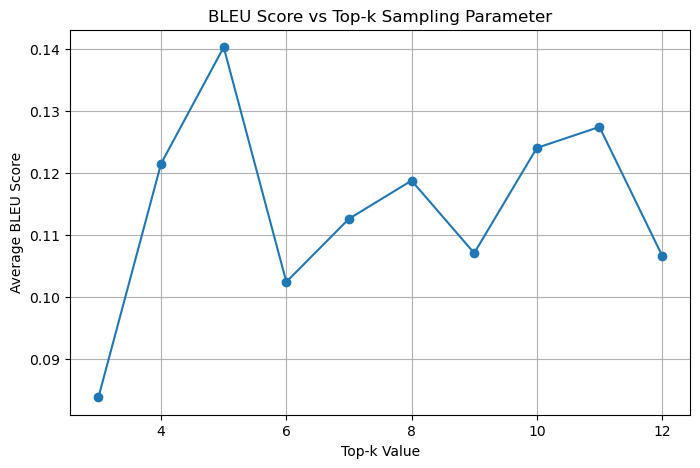

In [ ]:
# ==== 可视化 BLEU 分数与 top-k 关系 ====
plt.figure(figsize=(8,5))
plt.plot(topk_range, topk_bleu_scores, marker='o', color='tab:blue')
plt.title("BLEU Score vs Top-k Sampling Parameter")
plt.xlabel("Top-k Value")
plt.ylabel("Average BLEU Score")
plt.grid(True)
plt.show()

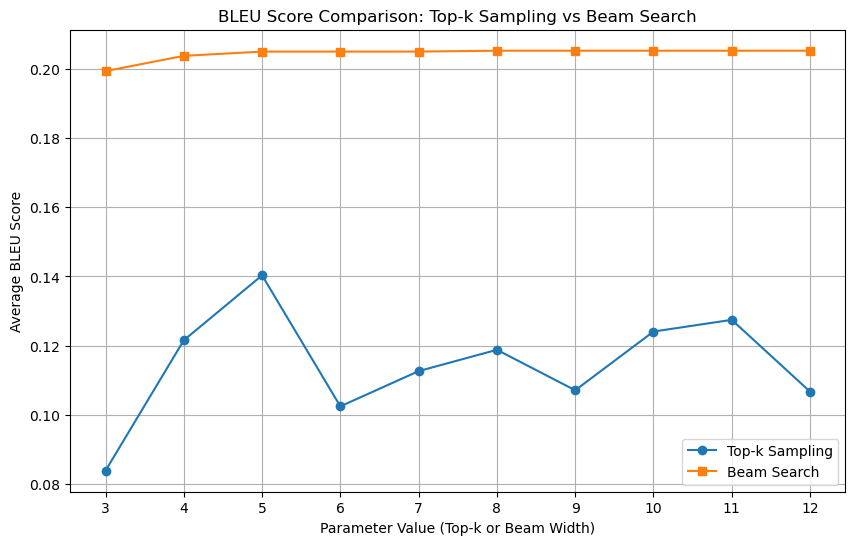

In [36]:
# 可视化对比
plt.figure(figsize=(10,6))
plt.plot(topk_range, topk_bleu_scores, marker='o', label='Top-k Sampling', color='tab:blue')
plt.plot(beam_range, beam_avg_bleus, marker='s', label='Beam Search', color='tab:orange')
plt.title("BLEU Score Comparison: Top-k Sampling vs Beam Search")
plt.xlabel("Parameter Value (Top-k or Beam Width)")
plt.ylabel("Average BLEU Score")
plt.xticks(topk_range)
plt.grid(True)
plt.legend()
plt.show()


综上可知，beam search（beam width=8）翻译函数表现最优。接下来尝试一下beam search的翻译效果。

In [37]:
output_path = "beam8_translations.txt"

with open("translation_samples.txt", encoding="utf-8") as f:
    lines = f.readlines()

with open(output_path, "w", encoding="utf-8") as f_out:
    for line in tqdm(lines, desc="Translating with Beam Width = 8"):
        if not line.strip():
            continue
        zh, en_ref = line.strip().split("\t")
        en_pred = translate(model, sp_src, sp_tgt, zh, mode="beam", beam_width=8)

        f_out.write(f"原文: {zh}\n")
        f_out.write(f"参考: {en_ref}\n")
        f_out.write(f"翻译: {en_pred}\n\n")

print(f"\n✅ 翻译完成，结果保存在: {output_path}")

Translating with Beam Width = 8: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


✅ 翻译完成，结果保存在: beam8_translations.txt


原文: 你好。
参考: Hello.
翻译: Hello there.

原文: 谢谢你。
参考: Thank you.
翻译: Thank you.

原文: 我喜欢这本书。
参考: I like this book.
翻译: And I loved this book.

原文: 今天天气很好。
参考: The weather is nice today.
翻译: It's very good weather.

原文: 他正在看电视。
参考: He is watching TV.
翻译: So he's walking.

原文: 她住在北京。
参考: She lives in Beijing.
翻译: She lives in Beijing.

原文: 我不喜欢咖啡。
参考: I don't like coffee.
翻译: I don't like coffee.

原文: 我昨天没去上班。
参考: I didn't go to work yesterday.
翻译: I wasn't there yesterday.

原文: 他已经完成了作业。
参考: He has already finished his homework.
翻译: He has done it.

原文: 你叫什么名字？
参考: What’s your name?
翻译: What is your name?

原文: 你会说英语吗？
参考: Can you speak English?
翻译: Can you speak English?

原文: 明天你有空吗？
参考: Are you free tomorrow?
翻译: Can you have another tomorrow?

原文: 虽然他很累，但他还是完成了工作。
参考: Although he was tired, he still finished the work.
翻译: He got angry, and he worked pretty well.

原文: 如果天气好，我们就去爬山。
参考: If the weather is good, we will go hiking.
翻译: If we go to the weather, we're going to get good weather.

原文: 我喜欢猫，因为它们很可爱。
参考: I like cats because they are cute.
翻译: I love cats, because they're cute.

原文: 近年来，人工智能的发展改变了我们的生活方式。
参考: In recent years, the development of artificial intelligence has changed our way of life.
翻译: And over the years, behavior has changed our lifestyle.

原文: 这个项目的目的是为了提高学生的英语口语能力。
参考: The purpose of this project is to improve students’ spoken English skills.
翻译: And the English medium focused on trying to express itself.

原文: 在未来的十年里，气候变化可能成为全球面临的最大挑战之一。
参考: In the next decade, climate change may become one of the greatest challenges the world faces.
翻译: Many of the biggest challenges in the next decade will be the decade of climate change.

原文: 他打了他一巴掌。
参考: He slapped him.
翻译: And he's following me over.

原文: 我以为你不会来了。
参考: I thought you wouldn’t come.
翻译: I thought you're okay.

原文: 我妈妈说我爸爸不在家。
参考: My mom said my dad wasn't home.
翻译: My mom says, "No dad's not in my family.


In [ ]:
# # 保存模型到网盘
# !cp transformer_translation.pt /content/drive/MyDrive/transformer_translation.pt
# !cp best_model.pt /content/drive/MyDrive/best_model.pt